# REINFORCEMENT LEARNING - PROJECT 3, PART 2

Aman Johar - 50320278  
Mudita Sanjive - 50322660

## 1. CREATE ACTOR-CRITIC NETWORK

In [1]:
import gym
import numpy as np
import tensorflow.compat.v1 as tf
import copy
tf.disable_v2_behavior()



class Policy_net:    
    def __init__(self, name: str, env, temp=0.1):
        ob_space = env.observation_space
        act_space = env.action_space

        with tf.variable_scope(name):
            self.obs = tf.placeholder(dtype=tf.float32, shape=[None] + list(ob_space.shape), name='obs')

            with tf.variable_scope('actor_model'):     #Actor's Neural Network
                layer_1 = tf.layers.dense(inputs=self.obs, units=20, activation=tf.tanh)
                layer_2 = tf.layers.dense(inputs=layer_1, units=20, activation=tf.tanh)
                layer_3 = tf.layers.dense(inputs=layer_2, units=act_space.n, activation=tf.tanh)
                self.act_probs = tf.layers.dense(inputs=tf.divide(layer_3, temp), units=act_space.n, activation=tf.nn.softmax) #outputs action probabilities

            with tf.variable_scope('critic_model'):   #Critic's Neural Network
                layer_1 = tf.layers.dense(inputs=self.obs, units=20, activation=tf.tanh)
                layer_2 = tf.layers.dense(inputs=layer_1, units=20, activation=tf.tanh)
                self.v_preds = tf.layers.dense(inputs=layer_2, units=1, activation=None) #outputs predicted state-values

            self.act_stochastic = tf.multinomial(tf.log(self.act_probs), num_samples=1)
            self.act_stochastic = tf.reshape(self.act_stochastic, shape=[-1])

            self.scope = tf.get_variable_scope().name

    def act(self, obs):    #returns randomly selected action
        return tf.get_default_session().run([self.act_stochastic, self.v_preds], feed_dict={self.obs: obs})

    def get_trainable_variables(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.scope)


Instructions for updating:
non-resource variables are not supported in the long term


## 2. PROXIMAL POLICY OPTIMIZATION

In [2]:
class PPOTrain:
    
    def __init__(self, Policy, Old_Policy, gamma, clip_value=0.2):
      

        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma

        pi_trainable = self.Policy.get_trainable_variables()          
        old_pi_trainable = self.Old_Policy.get_trainable_variables()
        c1 = 1
        
        with tf.variable_scope('assign_op'):
            self.assign_ops = []
            for v_old, v in zip(old_pi_trainable, pi_trainable):
                self.assign_ops.append(tf.assign(v_old, v))

       
        with tf.variable_scope('train_inp'):
            self.actions = tf.placeholder(dtype=tf.int32, shape=[None], name='actions')
            self.rewards = tf.placeholder(dtype=tf.float32, shape=[None], name='rewards')
            self.v_preds_next = tf.placeholder(dtype=tf.float32, shape=[None], name='v_preds_next')
            self.gaes = tf.placeholder(dtype=tf.float32, shape=[None], name='gaes')

        act_probs = self.Policy.act_probs
        act_probs_old = self.Old_Policy.act_probs

       
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        act_probs = tf.reduce_sum(act_probs, axis=1)

      
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        with tf.variable_scope('actor_loss'):
           
            ratios = tf.exp(tf.log(act_probs) - tf.log(act_probs_old))   #calculating the ratio of current policy wrt old policy
            clipped_ratios = tf.clip_by_value(ratios, clip_value_min=1 - clip_value, clip_value_max=1 + clip_value) #clip the ration in the range of (1+e, 1-e)
            loss_clip = tf.minimum(tf.multiply(self.gaes, ratios), tf.multiply(self.gaes, clipped_ratios)) #selecting the minimum of clipped and non clipped objective
            loss_clip = tf.reduce_mean(loss_clip)

        
        with tf.variable_scope('critic_loss'):  #critic loss calculated using mean squared error
            v_preds = self.Policy.v_preds
            loss_vf = tf.squared_difference(self.rewards + self.gamma * self.v_preds_next, v_preds) 
            loss_vf = tf.reduce_mean(loss_vf)

        
        with tf.variable_scope('entropy'):  #entropy is used to ensure exploratory behavior in the agent
            
            entropy = -tf.reduce_sum(self.Policy.act_probs *tf.log(tf.clip_by_value(self.Policy.act_probs, 1e-10, 1.0)), axis=1)
            entropy = tf.reduce_mean(entropy, axis=0)  
            tf.summary.scalar('entropy', entropy)

        with tf.variable_scope('loss'):
            loss = loss_clip - (c1*loss_vf) + (0.05 * entropy)
            loss = -loss  #negation of loss taken as gradient ascent needs to be considered 
            
    
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4, epsilon=1e-5)
        self.train_op = optimizer.minimize(loss, var_list=pi_trainable)

    
    def train(self, obs, actions, rewards, v_preds_next, gaes):
        tf.get_default_session().run([self.train_op], feed_dict={self.Policy.obs: obs,
                                                                 self.Old_Policy.obs: obs,
                                                                 self.actions: actions,
                                                                 self.rewards: rewards,
                                                                 self.v_preds_next: v_preds_next,
                                                                 self.gaes: gaes})


    def assign_policy_parameters(self):
       
        return tf.get_default_session().run(self.assign_ops)
    

    def get_gaes(self, rewards, v_preds, v_preds_next):   #calculates and returns the generalized advantage estimation
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
       
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)): 
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes

## 3. POLICY OPTIMIZATION WITH PENALIZED POINT PROBABILITY DISTANCE 

In [3]:
class POP3DTrain:
    
    
    def __init__(self, Policy, Old_Policy, gamma, clip_value=0.2):
      

        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        
        beta = 5.0
        c1 = 1
        pi_trainable = self.Policy.get_trainable_variables()
        old_pi_trainable = self.Old_Policy.get_trainable_variables()

        
        with tf.variable_scope('assign_op'):
            self.assign_ops = []
            for v_old, v in zip(old_pi_trainable, pi_trainable):
                self.assign_ops.append(tf.assign(v_old, v))

       
        with tf.variable_scope('train_inp'):
            self.actions = tf.placeholder(dtype=tf.int32, shape=[None], name='actions')
            self.rewards = tf.placeholder(dtype=tf.float32, shape=[None], name='rewards')
            self.v_preds_next = tf.placeholder(dtype=tf.float32, shape=[None], name='v_preds_next')
            self.gaes = tf.placeholder(dtype=tf.float32, shape=[None], name='gaes')

        act_probs = self.Policy.act_probs
        act_probs_old = self.Old_Policy.act_probs

       
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        act_probs = tf.reduce_sum(act_probs, axis=1)

      
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        with tf.variable_scope('actor_loss'):
            
            ratios = tf.exp(tf.log(act_probs) - tf.log(act_probs_old))
            #point probability distance as the square difference of current action probabilties and old action probabilties 
            ppd = tf.reduce_mean(tf.square(tf.log(act_probs) - tf.log(act_probs_old)))
            loss_clip = tf.multiply(self.gaes, ratios) + beta*ppd  #beta is the penalised coefficient
            loss_clip = tf.reduce_mean(loss_clip)

        
        with tf.variable_scope('critic_loss'):
            v_preds = self.Policy.v_preds
            loss_vf = tf.squared_difference(self.rewards + self.gamma * self.v_preds_next, v_preds)
            loss_vf = tf.reduce_mean(loss_vf)

        
        with tf.variable_scope('entropy'):
            
            entropy = -tf.reduce_sum(self.Policy.act_probs *tf.log(tf.clip_by_value(self.Policy.act_probs, 1e-10, 1.0)), axis=1)
            entropy = tf.reduce_mean(entropy, axis=0)  
        
        
        with tf.variable_scope('loss'):
            loss = loss_clip - (c1*loss_vf) + (0.05 * entropy)
            loss = -loss  
            
    
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4, epsilon=1e-5)
        self.train_op = optimizer.minimize(loss, var_list=pi_trainable)

    
    def train(self, obs, actions, rewards, v_preds_next, gaes):
        tf.get_default_session().run([self.train_op], feed_dict={self.Policy.obs: obs,
                                                                 self.Old_Policy.obs: obs,
                                                                 self.actions: actions,
                                                                 self.rewards: rewards,
                                                                 self.v_preds_next: v_preds_next,
                                                                 self.gaes: gaes})


    def assign_policy_parameters(self):
       
        return tf.get_default_session().run(self.assign_ops)
    

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
       
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)): 
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes

## 4. TRAINING THE ENVIRONMENT

In [4]:
episodes = 10000
environment1 = "LunarLander-v2"
environment2 = "CartPole-v0"
sum_rewards = []


env = gym.make(environment2)
env.seed(0)
ob_space = env.observation_space
Policy = Policy_net('policy', env)
Old_Policy = Policy_net('old_policy', env)
PPO = POP3DTrain(Policy, Old_Policy, gamma=0.95)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    obs = env.reset()
    reward = 0
    success_num = 0

    for iteration in range(episodes):  
        observations = []
        actions = []
        v_preds = []
        rewards = []
        run_policy_steps = 0
        while True:  
            run_policy_steps += 1
            obs = np.stack([obs]).astype(dtype=np.float32)  
            act, v_pred = Policy.act(obs=obs)

            act = np.asscalar(act)
            v_pred = np.asscalar(v_pred)

            observations.append(obs)
            actions.append(act)
            v_preds.append(v_pred)
            rewards.append(reward)

            next_obs, reward, done, info = env.step(act)

            if done:
                v_preds_next = v_preds[1:] + [0]  # next state of terminate state has 0 state value
                obs = env.reset()
                reward = -1
                break
            else:
                obs = next_obs


        print("Episode : ", iteration, " Rewards : ", sum(rewards))
        sum_rewards.append(sum(rewards))


        gaes = PPO.get_gaes(rewards=rewards, v_preds=v_preds, v_preds_next=v_preds_next)

        observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
        actions = np.array(actions).astype(dtype=np.int32)
        rewards = np.array(rewards).astype(dtype=np.float32)
        v_preds_next = np.array(v_preds_next).astype(dtype=np.float32)
        gaes = np.array(gaes).astype(dtype=np.float32)
        gaes = (gaes - gaes.mean()) / gaes.std()

        PPO.assign_policy_parameters()

        inp = [observations, actions, rewards, v_preds_next, gaes]

        for epoch in range(4):     #training mini-batches
            sample_indices = np.random.randint(low=0, high=observations.shape[0], size=64)  # indices are in [low, high)
            sampled_inp = [np.take(a=a, indices=sample_indices, axis=0) for a in inp]  # sample training data
            PPO.train(obs=sampled_inp[0],
                      actions=sampled_inp[1],
                      rewards=sampled_inp[2],
                      v_preds_next=sampled_inp[3],
                      gaes=sampled_inp[4])

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.random.categorical` instead.
Episode :  0  Rewards :  20.0
Episode :  1  Rewards :  10.0
Episode :  2  Rewards :  11.0
Episode :  3  Rewards :  40.0
Episode :  4  Rewards :  6.0
Episode :  5  Rewards :  10.0
Episode :  6  Rewards :  22.0
Episode :  7  Rewards :  21.0
Episode :  8  Rewards :  17.0
Episode :  9  Rewards :  11.0
Episode :  10  Rewards :  9.0
Episode :  11  Rewards :  6.0
Episode :  12  Rewards :  7.0
Episode :  13  Rewards :  31.0
Episode :  14  Rewards :  8.0
Episode :  15  Rewards :  8.0
Episode :  16  Rewards :  20.0
Episode :  17  Rewards :  9.0
Episode :  18  Rewards :  10.0
Episode :  19  Rewards :  7.0
Episode :  20  Rewards :  9.0
Episode :  21  Rewards :  7.0
Episode :  22  Rewards :  7.0
Episode :  23  Rewards :  9.0
Episode :  24  Rewards :  23.0
Episode :  25  Rewards :  8.0
Episode :  26  Rewards 

Episode :  240  Rewards :  27.0
Episode :  241  Rewards :  36.0
Episode :  242  Rewards :  17.0
Episode :  243  Rewards :  15.0
Episode :  244  Rewards :  12.0
Episode :  245  Rewards :  25.0
Episode :  246  Rewards :  20.0
Episode :  247  Rewards :  33.0
Episode :  248  Rewards :  13.0
Episode :  249  Rewards :  33.0
Episode :  250  Rewards :  29.0
Episode :  251  Rewards :  10.0
Episode :  252  Rewards :  23.0
Episode :  253  Rewards :  93.0
Episode :  254  Rewards :  51.0
Episode :  255  Rewards :  17.0
Episode :  256  Rewards :  50.0
Episode :  257  Rewards :  19.0
Episode :  258  Rewards :  35.0
Episode :  259  Rewards :  32.0
Episode :  260  Rewards :  19.0
Episode :  261  Rewards :  23.0
Episode :  262  Rewards :  12.0
Episode :  263  Rewards :  27.0
Episode :  264  Rewards :  8.0
Episode :  265  Rewards :  34.0
Episode :  266  Rewards :  11.0
Episode :  267  Rewards :  33.0
Episode :  268  Rewards :  38.0
Episode :  269  Rewards :  17.0
Episode :  270  Rewards :  25.0
Episode :

Episode :  496  Rewards :  169.0
Episode :  497  Rewards :  32.0
Episode :  498  Rewards :  94.0
Episode :  499  Rewards :  24.0
Episode :  500  Rewards :  157.0
Episode :  501  Rewards :  131.0
Episode :  502  Rewards :  24.0
Episode :  503  Rewards :  198.0
Episode :  504  Rewards :  116.0
Episode :  505  Rewards :  49.0
Episode :  506  Rewards :  158.0
Episode :  507  Rewards :  137.0
Episode :  508  Rewards :  113.0
Episode :  509  Rewards :  95.0
Episode :  510  Rewards :  133.0
Episode :  511  Rewards :  108.0
Episode :  512  Rewards :  115.0
Episode :  513  Rewards :  195.0
Episode :  514  Rewards :  176.0
Episode :  515  Rewards :  39.0
Episode :  516  Rewards :  150.0
Episode :  517  Rewards :  198.0
Episode :  518  Rewards :  198.0
Episode :  519  Rewards :  22.0
Episode :  520  Rewards :  119.0
Episode :  521  Rewards :  119.0
Episode :  522  Rewards :  33.0
Episode :  523  Rewards :  144.0
Episode :  524  Rewards :  165.0
Episode :  525  Rewards :  198.0
Episode :  526  Rew

Episode :  746  Rewards :  198.0
Episode :  747  Rewards :  198.0
Episode :  748  Rewards :  198.0
Episode :  749  Rewards :  198.0
Episode :  750  Rewards :  198.0
Episode :  751  Rewards :  106.0
Episode :  752  Rewards :  198.0
Episode :  753  Rewards :  198.0
Episode :  754  Rewards :  198.0
Episode :  755  Rewards :  198.0
Episode :  756  Rewards :  198.0
Episode :  757  Rewards :  198.0
Episode :  758  Rewards :  198.0
Episode :  759  Rewards :  30.0
Episode :  760  Rewards :  198.0
Episode :  761  Rewards :  134.0
Episode :  762  Rewards :  198.0
Episode :  763  Rewards :  141.0
Episode :  764  Rewards :  124.0
Episode :  765  Rewards :  198.0
Episode :  766  Rewards :  198.0
Episode :  767  Rewards :  79.0
Episode :  768  Rewards :  138.0
Episode :  769  Rewards :  198.0
Episode :  770  Rewards :  198.0
Episode :  771  Rewards :  198.0
Episode :  772  Rewards :  198.0
Episode :  773  Rewards :  183.0
Episode :  774  Rewards :  118.0
Episode :  775  Rewards :  198.0
Episode :  7

Episode :  996  Rewards :  198.0
Episode :  997  Rewards :  198.0
Episode :  998  Rewards :  198.0
Episode :  999  Rewards :  198.0
Episode :  1000  Rewards :  198.0
Episode :  1001  Rewards :  118.0
Episode :  1002  Rewards :  198.0
Episode :  1003  Rewards :  165.0
Episode :  1004  Rewards :  198.0


KeyboardInterrupt: 

## 5. PLOTTING THE GRAPHS

### A. LunarLander-v2 with PPO

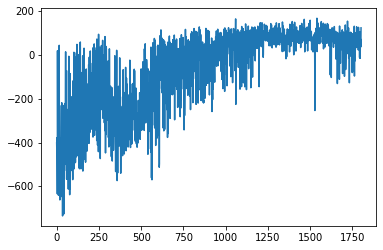

In [5]:
import matplotlib.pyplot as plt
plt.plot(sum_rewards)

### B. LunarLander-v2 with POP3D

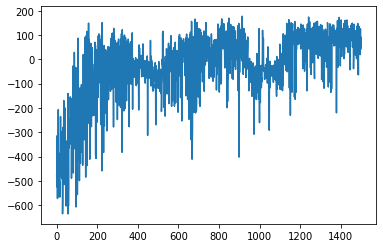

In [6]:
import matplotlib.pyplot as plt
plt.plot(sum_rewards[:1500])

### C. CartPole-v0 with PPO

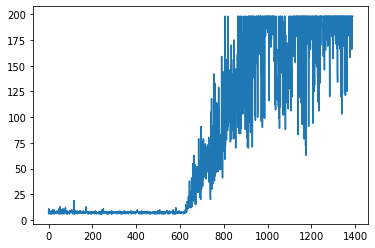

In [5]:
import matplotlib.pyplot as plt
plt.plot(sum_rewards)

### D. CartPole-v0 with POP3D

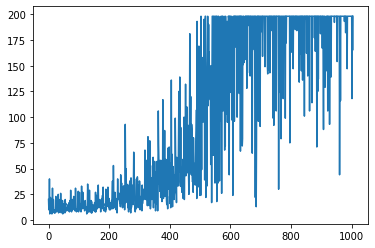

In [6]:
import matplotlib.pyplot as plt
plt.plot(sum_rewards)